# Classifiying of Traffic Signs using Convolutional Neural Network

## Executive Summary

Classifying the traffic sign is a crucial task in
autonomous driving system. This task is
accomplished by deploying a machine learning
technique to train a real-world data aka traffic sign
images in this project. Convolutional Neural Network
(CNN) is one of most popular and reliable techniques
to classify an image. In this project a CNN is
developed with reference to LeNet architecture
which is a state of art for MINIST data. In the
project, CNN is developed to classify the image in
terms of traffic sign-shape and sign-type. Data
augmentation is carried out with different
transformations to balance the data and to flatten
out the validation error. Hyperparameters are like
selected empirically by choosing the higher values
first and then pruned to an optimal value. 

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import torch.utils
import numpy as np
import pandas as pd
import glob
import os
import shutil
import zipfile
from sklearn.metrics import confusion_matrix
from pdb import set_trace

## Import the data

In [2]:
 with zipfile.ZipFile('trafficsigns_dataset-1.zip', 'r') as zip_ref:
     zip_ref.extractall('./')

## Convolutional Neural Network : LeNet5

The CNN model built in this project is a version of LeNet(LeNet-5) which is proposed by Lecun Y[],
which is initial used to classify the handwritten digits in MINIST dataset. LeNet-5 consists of seven
layers as described below
1. Layer 1: This convolution layer with six convolution layer with 3x3 square convolution and the size of the feature mapping is 28x28 with 6 output channels.
2.  Layer 2: Pooling layer or sub-sampling using the max pooling with a filter size of 2x2 and a stride of 2. The output of this layer gives us a feature mapping of 14x14 with 6 output channels.
3. Layer 3: This layer consists of 16 convolution layer with 3x3 square convolution and the size of the feature mapping is 10x10.
4. Layer 4: This sub-pooling layer with max pooling again, is same as previous pooling layer with 16 feature maps thus gives us output of 16x6x6.
5. Layer 5: This convolutional layer is fully connected with 120 feature maps. Each of 120 units in C5 is fully connected to all the nodes in the S4 layer.
6. Fully Connected Layer: This layer is fully connected with 84 units.
7. Output: This layer is a fully connected SoftMax output layer with n-classes in the data.

Reference for LeNet5 : LeCun, Y.; Bottou, L.; Bengio, Y. & Haffner, P. (1998). Gradient-based learning applied to document recognition.Proceedings of the IEEE. 86(11): 2278 - 2324.[4]

### Activation function:

The major advantage of ReLU function is it will be reduced likelihood of the gradient to vanish. On
the other hand, the gradient of sigmoid, Tanh function, will become increasingly small as the
absolute values of input feature increases. Thus, the constant gradient of ReLU results in faster
learning than Tanh function.

#### Note:

In this study , LeNet5 is used for classification task, the choice of CNN is considered according to size and pixels of the image provided in the assignment. The scope for more advanced networks like ResNet, DarkNet can be performed for better performnce which can be observed in many papers for the original Traffic Light dataset (European Traffic Light Classification dataset) but this study is limited to conventional CNN as per the task provided.

In [3]:
np.random.seed(9)
torch.manual_seed(9)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class LeNet(nn.Module):

    def __init__(self,num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, w):
        w = F.max_pool2d(F.relu(self.conv1(w)), (2, 2))
        w = F.max_pool2d(F.relu(self.conv2(w)), (2, 2))
        #print(self.num_flat_features(w))
        w = w.view(-1, self.num_flat_features(w))
        w = F.relu(self.fc1(w))
        w = F.relu(self.fc2(w))
        w = self.fc3(w)
        return w

    def num_flat_features(self, n):
        size = n.size()[1:]
        num_features = 1
        for i in size:
            num_features *= i
        return num_features


## Train function

In [4]:

def train(epoch, loader, classifier, criterion, optimizer, run_name):

    classifier.train()
    loss_r = 0.
    m = nn.Softmax(dim=1)
    pd.DataFrame({'epoch': [], 'groundtruth': [], 'preds': []}).to_csv('training_performance.csv', header=True,
                                                          index=False, mode='w')

    for i, (input_tensor, target_tensor) in enumerate(loader):
         output = classifier(input_tensor)
         #train_t = torch.eq(torch.argmax(m(output), dim=1), target_tensor)#boolean array
         #batch_accuracy = train_t.sum().item() / len(target_tensor)
         loss = criterion(output, target_tensor)
         optimizer.zero_grad()
         loss.backward()
         optimizer.step()
         pd.DataFrame({'epoch': [epoch] * len(target_tensor),
                       'groundtruth': target_tensor.detach().numpy(),
                       'preds': torch.argmax(m(output), dim=1).detach().numpy()}).to_csv(
                       'training_performance.csv', header=False,index=False, mode='a')
         #loss_r += loss.item()
         # print('training {}/{}'.format(i, len(loader)))
    metrics = pd.read_csv('training_performance.csv')
    train_loss=loss.item()
    train_t = np.equal(metrics.groundtruth,metrics.preds)  # boolean array
    train_acc = train_t.sum() / len(metrics)
    # print('Epoch acc:',train_acc)

    torch.save(classifier.state_dict(), os.path.join(run_name+'_checkpoints', '{}_checkpoint.pth'.format(epoch)))
    #print(train_loss)
    return train_acc, train_loss

## Validation function

In [5]:
def val(epoch, loader, classifier, criterion):
    classifier.eval()
    accuracy = 0.
    val_groundtruth = []
    val_preds = []

    m = nn.Softmax(dim=1)

    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(loader):
            # print('validation {}/{}'.format(i, len(loader)))

            output = classifier(input_tensor)
            loss = criterion(output, target_tensor)

            preds = torch.argmax(m(output), dim=1)
            val_t = torch.eq(preds, target_tensor)
            primary_a = val_t.sum().item() / len(target_tensor)
            accuracy += primary_a

            val_groundtruth.append(target_tensor)
            val_preds.append(preds)
    #print(loss.item())        
    return val_groundtruth, val_preds, loss.item()

## Run_train_and_validation

This helper function is used to perform both training and validation task with respective transformations. 

Optimisation:

In this project, I have used Stochastic Gradient descent as my optimisation parameter
for the model. The main reason to use this optimisation is based on discussion made on Gradient
descent and mini batching methods popularly used in deep learning literature. 

Loss Criterion:

Since the dataset provided with ‘n’ classes for each task, I have chosen cross entropy
loss function which will minimise the distance between the probability distribution of the classes.
Thus, we make room for more likelihood than a random guess.

Hyper parameters:

Generally chosen empirically. Hyper parameters are usually selected empirically, for this project
learning rate (0.01), batch size (32) yield best result in the first go and epochs 25,50  (chosen 50 for the final model) are considered as hyperparameters.

In [6]:
def train_val_loader(train_dataset_directory, val_dataset_directory,epochs, run_name,train_transforms,val_transforms):
    
    train_data = torchvision.datasets.ImageFolder(train_dataset_directory, transform=train_transforms)
   
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=32, shuffle=True, num_workers=4)

    val_data = torchvision.datasets.ImageFolder(val_dataset_directory, transform=val_transforms)
    val_loader = torch.utils.data.DataLoader(val_data,batch_size=32, shuffle=True, num_workers=4)

   
     # load model
    classifier = LeNet(num_classes=len(train_data.classes))
    # optimizer = optim.Adam(classifier.parameters())
    optimizer = optim.SGD(classifier.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss() ##nll
    
    shutil.rmtree(run_name + '_checkpoints', ignore_errors=True)
    os.makedirs(run_name + '_checkpoints', exist_ok=True)
    
    np.random.seed(9)
    with open(run_name+'_confusion_matrix.csv', 'w') as f: f.write('validation performance\n')
    
    
    # train and validate

    pd.DataFrame({'epoch': [], 'train_accuracy': [], 'val_accuracy': []}).to_csv(run_name+'_accuracy_performance.csv',
                                                                                 header=True,
                                                                                 index=False, mode='w')#
    pd.DataFrame({'epoch': [], 'train_loss': [], 'val_loss': []}).to_csv(run_name+'_loss_performance.csv', header=True,
                                                                         index=False, mode='w')
    shutil.rmtree(run_name + '_checkpoints', ignore_errors=True)
    os.makedirs(run_name + '_checkpoints', exist_ok=True)
    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(epoch, train_loader, classifier, criterion, optimizer, run_name)

        val_groundtruth, val_preds, val_loss = val(epoch, val_loader, classifier, criterion)
        val_groundtruth = torch.cat(val_groundtruth).cpu().numpy()
        val_preds = torch.cat(val_preds).cpu().numpy()
        val_accuracy = (np.equal(val_groundtruth, val_preds).sum()) / len(val_groundtruth)  # boolean array

        with open(run_name+'_confusion_matrix.csv', 'a') as f: f.write('\nepoch {}\n'.format(epoch))
        pd.DataFrame(confusion_matrix(val_groundtruth, val_preds)).to_csv(run_name+'_confusion_matrix.csv', mode='a',
                                                                          index=False,
                                                                          header=False)

        pd.DataFrame({'epoch': [epoch], 'train_accuracy': [epoch_train_acc], 'val_accuracy': [val_accuracy]}).to_csv(
            run_name+'_accuracy_performance.csv', header=False, index=False, mode='a')
        pd.DataFrame({'epoch': [epoch], 'train_loss': [epoch_train_loss], 'val_loss': [val_loss]}).to_csv(
            run_name+'_loss_performance.csv', header=False, index=False, mode='a')
    x = pd.read_csv(run_name+'_accuracy_performance.csv')
    x.plot.line(x='epoch', y=['train_accuracy', 'val_accuracy']).get_figure().savefig(
                                                                            run_name+'_accuracy_plot.png')
    
   

    y = pd.read_csv(run_name+'_loss_performance.csv')
    y.plot.line(x='epoch', y=['train_loss', 'val_loss']).get_figure().savefig(
                                                    run_name+'_loss_plot.png')
  

In [7]:
def run_without_transforms(train_dataset_directory, val_dataset_directory,epoch, run_name):
    selected_transforms= transforms.Compose([transforms.Grayscale(),
                                             transforms.Pad(2, fill=0),
                                             transforms.ToTensor()])
   
    train_val_loader(train_dataset_directory, val_dataset_directory,epoch, run_name,selected_transforms,selected_transforms)
 

    

## Data Agumentation 

In [8]:
def run_with_transforms(train_dataset_directory, val_dataset_directory,epoch, run_name):

    train_transforms = transforms.Compose([transforms.Grayscale(),
                                          transforms.RandomRotation(10, fill=(0,)),
                                          transforms.RandomHorizontalFlip(p=0.5),
                                          transforms.RandomVerticalFlip(p=0.5),
                                          transforms.Pad(2, fill=0),
                                          transforms.ToTensor()])
    val_transforms = transforms.Compose([transforms.Grayscale(),
                                          transforms.Pad(2, fill=0),
                                          transforms.ToTensor()])
    train_val_loader(train_dataset_directory, val_dataset_directory,epoch, run_name,train_transforms,val_transforms)

# Spliting the dataset

## Data Preprocessing

### Imbalanced Data

 SPLIT BY SHAPES

In [9]:
def split_shapes_imbalanced():
    x = pd.DataFrame({'images':glob.glob("trafficsigns_dataset//**/*.png", recursive=True)})
    x = x.sample(frac=1.0, random_state=9)
    x['shapes'] = x.images.apply(lambda i: i.split('/')[1]) # shapes

    # delete existing directories
    shutil.rmtree('training_dataset_imbalanced_shapes', ignore_errors=True)
    shutil.rmtree('validation_dataset_imbalanced_shapes', ignore_errors=True)
    shutil.rmtree('test_dataset_imbalanced_shapes', ignore_errors=True)
    os.makedirs('training_dataset_imbalanced_shapes', exist_ok=True)
    for i in x.shapes.unique(): os.makedirs(os.path.join('training_dataset_imbalanced_shapes', i), exist_ok=True)
    shutil.copytree('training_dataset_imbalanced_shapes', 'validation_dataset_imbalanced_shapes')
    shutil.copytree('training_dataset_imbalanced_shapes', 'test_dataset_imbalanced_shapes')

    train_paths = x.groupby('shapes').apply(lambda i: i[:round(0.8*len(i))]).reset_index(drop=True)
    val_paths = x.groupby('shapes').apply(lambda i: i[round(0.8*len(i)): round(0.8*len(i))+round(
                                                                                    0.1*len(i))]).reset_index(drop=True)
    test_paths = x.groupby('shapes').apply(lambda i: i[round(0.9*len(i)):]).reset_index(drop=True)
    for shape_name, image_path in zip(train_paths.shapes, train_paths.images):
                                                            shutil.copy(image_path,os.path.join(
                                                                                'training_dataset_imbalanced_shapes',
                                                                                                shape_name))
    for shape_name, image_path in zip(val_paths.shapes, val_paths.images): shutil.copy(
                                                                            image_path, os.path.join(
                                                                                'validation_dataset_imbalanced_shapes',
                                                                                shape_name))
    for shape_name, image_path in zip(test_paths.shapes, test_paths.images): shutil.copy(image_path, 
                                                                                         os.path.join(
                                                                                       'test_dataset_imbalanced_shapes', 
                                                                                            shape_name))


SPLIT BY SIGNS

In [10]:
def split_signs_imbalanced():
    x = pd.DataFrame({'images':glob.glob("trafficsigns_dataset//**/*.png", recursive=True)})
    x = x.sample(frac=1.0, random_state=9)
    x['signs'] = x.images.apply(lambda i: i.split('/')[2]) # shapes

    # delete existing directories
    shutil.rmtree('training_dataset_imbalanced_signs', ignore_errors=True)
    shutil.rmtree('validation_dataset_imbalanced_signs', ignore_errors=True)
    shutil.rmtree('test_dataset_imbalanced_signs', ignore_errors=True)
    os.makedirs('training_dataset_imbalanced_signs', exist_ok=True)
    for i in x.signs.unique(): os.makedirs(os.path.join('training_dataset_imbalanced_signs', i), exist_ok=True)
    shutil.copytree('training_dataset_imbalanced_signs', 'validation_dataset_imbalanced_signs')
    shutil.copytree('training_dataset_imbalanced_signs', 'test_dataset_imbalanced_signs')

    train_paths = x.groupby('signs').apply(lambda i: i[:round(0.8*len(i))]).reset_index(drop=True)
    val_paths = x.groupby('signs').apply(lambda i: i[round(0.8*len(i)): round(0.8*len(i))+
                                                     round(0.1*len(i))]).reset_index(drop=True)
    test_paths = x.groupby('signs').apply(lambda i: i[round(0.9*len(i)):]).reset_index(drop=True)
    for sign_name, image_path in zip(train_paths.signs, train_paths.images):
                                             shutil.copy(image_path,os.path.join('training_dataset_imbalanced_signs',
                                                                                 sign_name))
    for sign_name, image_path in zip(val_paths.signs, val_paths.images):
                                             shutil.copy(image_path, os.path.join('validation_dataset_imbalanced_signs', 
                                                                                  sign_name))
    for sign_name, image_path in zip(test_paths.signs, test_paths.images):
                                             shutil.copy(image_path, os.path.join('test_dataset_imbalanced_signs',
                                                                                  sign_name))


In [11]:
split_shapes_imbalanced()

In [12]:
split_signs_imbalanced()

## Results of imbalanced dataset

The accuracy at the ending of  'n'  epochs is high enough with more than 90% classification accuracyboth on training and validation dataset but the major flaw is observed in loss of the training and validation, they never converge due to imabalanced data in both the models( with and without transformations)

#### Classifying the Shapes

In [13]:
 run_without_transforms("training_dataset_imbalanced_shapes", "validation_dataset_imbalanced_shapes",30, "imbalanced_dataset_shapes_without_transforms")

Data agumentation: Horizontal Filp, Vertical Flip, Rotation

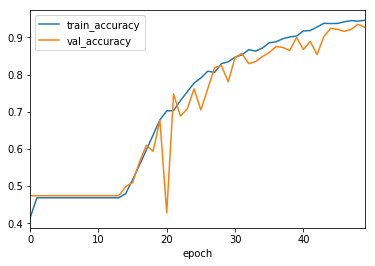

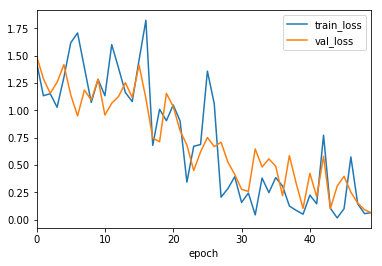

In [14]:
run_with_transforms("training_dataset_imbalanced_shapes", "validation_dataset_imbalanced_shapes",50, "imbalanced_dataset_shapes_with_transforms")

#### Classifying the Signs

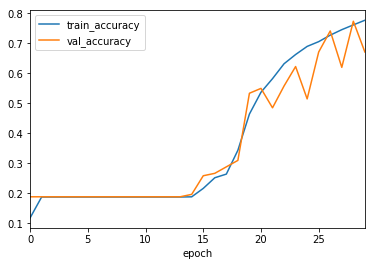

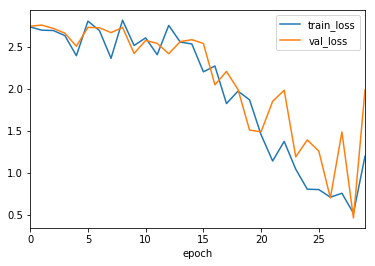

In [15]:
 run_without_transforms("training_dataset_imbalanced_signs", "validation_dataset_imbalanced_signs",30, 
                        "imbalanced_dataset_signs_without_transforms")

Data agumentation: Horizontal Filp, Vertical Flip, Rotation

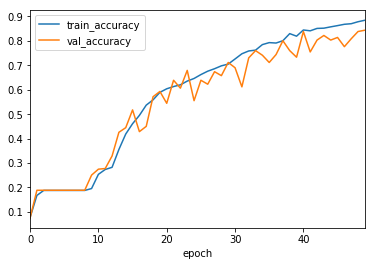

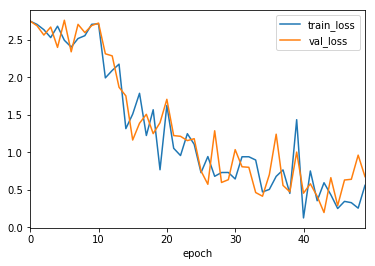

In [16]:
run_with_transforms("training_dataset_imbalanced_signs", "validation_dataset_imbalanced_signs",50,
                    "imbalanced_dataset_signs_transforms")

## Balancing the dataset : Oversampling 

As above , we can see how imbalanced dataset fail in minimisation of loss. Balancing the data will improve the loss function to converge due to two reasons:

1. Oversampling: Creating synthetic examples in minority classes. Thus, we will not lose the information instead we make same instance selected randomly and make a copy of them 

2. The dataset size , number of instances (images) is equall in class. Thus precision rate will be evaluated for 'n' classes with 'm' instances where 'm' is constant in each classification


###### SPLIT BY SHAPES :

In [17]:

def split_shapes():
    x = pd.DataFrame({'images':glob.glob("trafficsigns_dataset//**/*.png", recursive=True)})
    x = x.sample(frac=1.0, random_state=9)
    x['shapes'] = x.images.apply(lambda i: i.split('/')[1]) # shapes


    # delete existing directories
    shutil.rmtree('training_dataset_shapes', ignore_errors=True)
    shutil.rmtree('validation_dataset_shapes', ignore_errors=True)
    shutil.rmtree('test_dataset_shapes', ignore_errors=True)
    os.makedirs('training_dataset_shapes', exist_ok=True)
    for i in x.shapes.unique(): os.makedirs(os.path.join('training_dataset_shapes', i), exist_ok=True)
    shutil.copytree('training_dataset_shapes', 'validation_dataset_shapes')
    shutil.copytree('training_dataset_shapes', 'test_dataset_shapes')

    train_paths = x.groupby('shapes').apply(lambda i: i[:round(0.8*len(i))]).reset_index(drop=True)
    val_paths = x.groupby('shapes').apply(
                    lambda i: i[round(0.8*len(i)): round(0.8*len(i))+round(0.1*len(i))]).reset_index(drop=True)
    test_paths = x.groupby('shapes').apply(lambda i: i[round(0.9*len(i)):]).reset_index(drop=True)

    #get the class with maximum images and replace the minority classes with same samples 
    size_of_max_class = train_paths.shapes.value_counts().max()
    train_paths = train_paths.groupby('shapes').apply(lambda i: pd.concat([i, i.sample(size_of_max_class - len(i), 
                                                                                 replace=True)])).reset_index(drop=True)

    for sample_idx, shape_name, image_path in zip(range(len(train_paths)),  train_paths.shapes, train_paths.images): 
                                                    shutil.copy(image_path, os.path.join('training_dataset_shapes', 
                                                                     shape_name,'{}_{}'.format(
                                                                         sample_idx,os.path.basename(image_path))))
    for shape_name, image_path in zip(val_paths.shapes, val_paths.images): shutil.copy(image_path, os.path.join(
                                                                                    'validation_dataset_shapes', shape_name))
    for shape_name, image_path in zip(test_paths.shapes, test_paths.images): shutil.copy(image_path, 
                                                                                         os.path.join('test_dataset_shapes', 
                                                                                                      shape_name))

###### SPLIT BY SIGNS :

In [18]:
def split_signs():
   
    x_signs = pd.DataFrame({'images':glob.glob("trafficsigns_dataset//**/*.png", recursive=True)})
    x_signs = x_signs.sample(frac=1.0, random_state=9)
    x_signs['signs'] = x_signs.images.apply(lambda i: i.split('/')[2]) # signs
    # delete existing directories
    shutil.rmtree('training_dataset_sign', ignore_errors=True)
    shutil.rmtree('validation_dataset_sign', ignore_errors=True)
    shutil.rmtree('test_dataset_sign', ignore_errors=True)
    os.makedirs('training_dataset_sign', exist_ok=True)
    for i in x_signs.signs.unique(): os.makedirs(os.path.join('training_dataset_sign', i), exist_ok=True)
    shutil.copytree('training_dataset_sign', 'validation_dataset_sign')
    shutil.copytree('training_dataset_sign', 'test_dataset_sign')

    train_paths = x_signs.groupby('signs').apply(lambda i: i[:round(0.8 * len(i))]).reset_index(drop=True)
    val_paths = x_signs.groupby('signs').apply(
        lambda i: i[round(0.8 * len(i)): round(0.8 * len(i)) + round(0.1 * len(i))]).reset_index(drop=True)
    test_paths = x_signs.groupby('signs').apply(lambda i: i[round(0.9 * len(i)):]).reset_index(drop=True)

    size_of_max_class = train_paths.signs.value_counts().max()
    train_paths = train_paths.groupby('signs').apply(
        lambda i: pd.concat([i, i.sample(size_of_max_class - len(i), replace=True)])).reset_index(drop=True)

    for sample_idx, sign_name, image_path in zip(range(len(train_paths)), train_paths.signs,
                                                 train_paths.images): shutil.copy(image_path,
                                                                                  os.path.join('training_dataset_sign',
                                                                                               sign_name,
                                                                                               '{}_{}'.format(
                                                                                                   sample_idx,
                                                                                                   os.path.basename(
                                                                                                       image_path))))
    for sign_name, image_path in zip(val_paths.signs, val_paths.images): shutil.copy(image_path, os.path.join(
        'validation_dataset_sign', sign_name))
    for sign_name, image_path in zip(test_paths.signs, test_paths.images): shutil.copy(image_path,
                                                                                      os.path.join('test_dataset_sign',
                                                                                                   sign_name))


#### Classification of balanced data

In [19]:
split_shapes()

In [20]:
split_signs()

#### Shapes

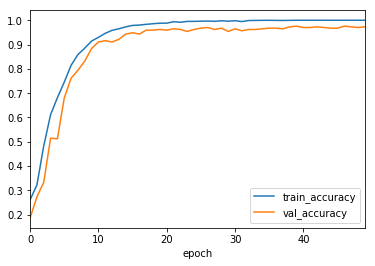

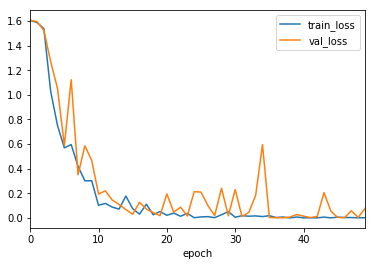

In [21]:
 run_without_transforms("training_dataset_shapes", "validation_dataset_shapes",50, "balanced_dataset_without_transformation")

Data agumentation: Horizontal Filp, Vertical Flip, Rotation

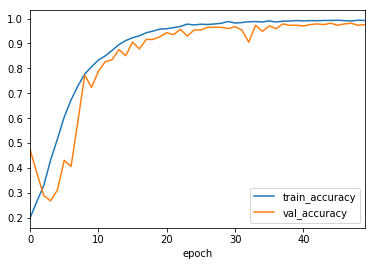

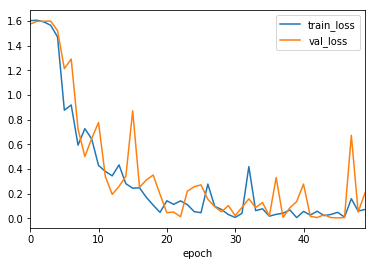

In [22]:
run_with_transforms("training_dataset_shapes", "validation_dataset_shapes",50, "balanced_dataset_shapes_tranforms")

#### Classifying the Signs

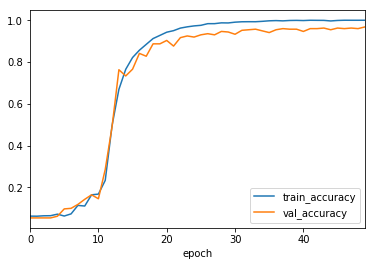

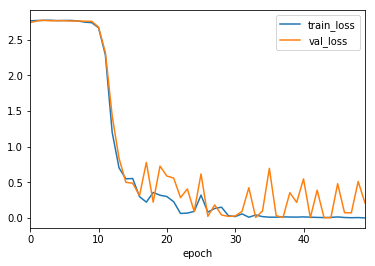

In [23]:
 run_without_transforms("training_dataset_sign", "validation_dataset_sign",50, "balanced_dataset_signs_without_transforms")

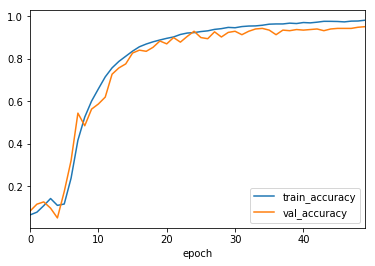

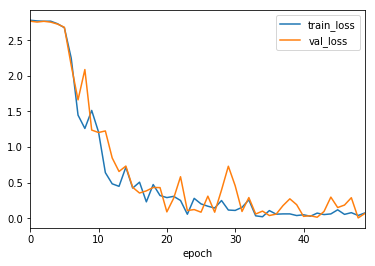

In [24]:
run_with_transforms("training_dataset_sign", "validation_dataset_sign",50, "balanced_dataset_sign_with_transforms")

## Testing Function

In [25]:
def testset_performance(test_dataset_directory,checkpoint, run_name,num_classes=16,data_name=None):
    # 'independent' is to carry test any other dataset to test model overall performance(real-time test ) 
    if data_name == 'independent':
        test_transforms = transforms.Compose([transforms.Grayscale(),transforms.Resize((32,32)),
                                     transforms.ToTensor()])
    else:
        test_transforms = transforms.Compose([transforms.Grayscale(),
                                         transforms.Pad(2, fill=0),
                                         transforms.ToTensor()])
    test_data = torchvision.datasets.ImageFolder(test_dataset_directory, transform=test_transforms)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)
    
    # load model
    classifier = LeNet(num_classes)
    classifier.load_state_dict(torch.load(checkpoint))
    optimizer = optim.SGD(classifier.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    shutil.rmtree(run_name + '_checkpoints', ignore_errors=True)
    os.makedirs(run_name + '_checkpoints', exist_ok=True)
    
    np.random.seed(9)
    with open(run_name + '_confusion_matrix.csv', 'w') as f: f.write('testset performance\n')

    # testset performance
    test_groundtruth, test_preds, test_loss = val(0, test_loader, classifier, criterion)
    test_groundtruth = torch.cat(test_groundtruth).cpu().numpy()
    test_preds = torch.cat(test_preds).cpu().numpy()
    test_accuracy = (np.equal(test_groundtruth, test_preds).sum()) / len(test_groundtruth)  # boolean array
    print(test_data.imgs[test_accuracy == False])
    print(test_accuracy)

    with open(run_name + '_confusion_matrix.csv', 'a') as f: f.write('\Test accuracy {}\n'.format(test_accuracy))
    pd.DataFrame(confusion_matrix(test_groundtruth, test_preds)).to_csv(run_name + '_confusion_matrix.csv', mode='a',
                                                                      index=False,
                                                                      header=False)


### Testing for shapes and signs 

It is observed that, the accuracy of both train and validation are achieving the convergence with an approximate of 0.1 error rate. This model is tested on a holdout dataset, thus making sure our model is viable to real world data.

Test accuracy for task of classifying the signs is 93.2 % and for the task of classifying the shapes 96.4%.

In [27]:
testset_performance('test_dataset_shapes','balanced_dataset_shapes_tranforms_checkpoints/49_checkpoint.pth', 
                    'test_performace_shapes_with_transformations', num_classes=5)

('test_dataset_shapes/diamond/00103_00002.png', 0)
0.9648648648648649


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [28]:
testset_performance('test_dataset_sign','balanced_dataset_sign_with_transforms_checkpoints/49_checkpoint.pth',
                    'test_performace_sign_with_transformations', num_classes=16)

('test_dataset_sign/bicycle/00004_00000.png', 0)
0.9322493224932249


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:29: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


## Limitations 

1. The major limitation is the data. The problem statement as mentioned, Classification of Traffic Signs, might be interested of ‘Transfer Learning’ but the rules in each country changes in one way or the other as explained above makes the model performance suppress lack of experience.

2. This model is not a pretrianed model, this makes the model more complicated. The one only advantage of deep learning is to use vast amount of data and performance different task only model, atleast in classification task. Pretraining models with different weights corresponding to different classes will ensure more accuracy and correctness.

3. To apply deep learning and computer vision techniques to detect object boundaries in a spectrum of images(like a big Landscape ,road and traffic sign), we need more diverse data and rich in both quality and quantity of data to serve the purpose of Advanced Driver Assistance Systems (ADAS).